In [1]:
import numpy as np
import networkx as nx
from scipy.sparse import csc_matrix
from networkx.algorithms import community
import matplotlib.pyplot as plt
import psycopg2 as pg2
from pprint import pprint
import pandas as pd
import pickle

In [2]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="/home/consulting/Jupyter/smnoh/font/NanumGothic.ttf").get_name()
rc('font', family=font_name)

### Hierarchical Graph Clustering using Girvan-Newman clustering
https://www.pnas.org/content/99/12/7821

In [3]:
def GN_HC(G): 
    # g는 Edge를 끊어나가는 네트워크 
    g = G.copy()
    """ initial """
    step = 0                # step 초기화
    log_step = []           # step 기록
    log_modularity = []     # modularity 기록
    log_num=[]              # cluster 갯수 기록 
    k = sorted(nx.connected_components(G), key=len, reverse=True)   # k 는 모두 연결되어있는 Community를 노드로 나타낸 값
    m = community.modularity(G, communities=k)   # modularity
    k_num=0
    target_k=[]   #각각의 k_list를 다 더한게 target_k
    
    num_edges=[] #엣지 개수 기록
    """ Girvan-Newman algorithm """
    #엣지가 다 없어질때까지 계속함?? 
    while len(g.edges()) > 0:
        # 지금 연결된 component들
        k = sorted(nx.connected_components(g), key=len, reverse=True)  # 커뮤니티 추출
        m = community.modularity(G, communities=k)   # 추출된 커뮤니티의 modularity 계산
        k_list = []
        num_edge = g.number_of_edges()
        
        for j in range(len(k)):
            k_list.append(k[j])  # 단계마다의 k를 k_list에 담음?? 
        #print(k_list)
        
        #새로운 클러스터의 개수가 기존 클러스터의 개수보다 크다면, 
        if len(k_list)>k_num: # 클러스터 갯수가 변할때마다 기록(1부터 시작), 여기에서의 k_num은 엣지가 제거되기 전의 클러스터 개수
            target_k.append(k_list) #결국에 target_k의 요소들은 다 k들임(component). k[i]는 커뮤니티개수가 i일 때의 커뮤니티가 아님
            k_num=len(k_list)  # 클러스터의 개수?? 
            log_modularity.append(m)   # 로깅용
            log_step.append(step)    # 로깅용
            log_num.append(k_num)
            num_edges.append(num_edge)
        
        """ remove edge """
        step += 1
        betweenness = nx.edge_betweenness_centrality(g)  # betweennes centrality 계산
        max_edge = max(betweenness, key=betweenness.get)    # betweeness centrality가 가장 큰 Edge 선택
        g.remove_edge(max_edge[0], max_edge[1])     # 선택된 Edge 제거
        #다시 돌아가면 엣지가 하나 제거된 그래프의 컴포넌트부터 계산해서 다시 시작됨. 
        
    return log_step, log_modularity, log_num, num_edges, target_k

In [4]:
# cluster 리스트에서 원하는 cluster 갯수 만큼 추출
def find_cluster(n):
    global log_num, target_k
    #pprint(target_k[n-1])
    return target_k[n-1]

### 뉴스 데이터로 그래프 생성

#### 방향성 없는 graph 생성

In [5]:
# connect PostgreSQL
def query_agens(query):
    import psycopg2 as pg2
    from psycopg2 import Error
    from datetime import datetime
    
    start_tm = datetime.now()
    conn = pg2.connect(database="kg_news", user="consulting", host="192.168.0.68", port="15432")
    cur = conn.cursor()

    path_query = "set graph_path = realestate_news_v3;"
    cur.execute(path_query)
    cur.execute(query)
    result = cur.fetchall()
    
    cur.close()
    conn.close()
    
    end_tm = datetime.now()
    print('START: ', str(start_tm))
    print('END: ', str(end_tm))
    print('ELAP: ', str(end_tm - start_tm))
    
    return result

In [6]:
query = """match (s:noun)-[p:predicate]->(o:noun) return s.word, p.verb, o.word"""
result = query_agens(query)
data = pd.DataFrame(result, columns=['subject', 'predicate', 'object'])
data

START:  2021-01-27 10:43:50.892105
END:  2021-01-27 10:43:50.911006
ELAP:  0:00:00.018901


,subject,predicate,object
0,정부,발표하다,임대주택 공급
1,정부,위하다,전세시장안정
2,정부,계획이다,전세 대책 발표
3,정부,진행하다,관계부처간 협의
4,정부,옳다,대응방안 마련
...,...,...,...
964,공공임대,필수적이다,지속성
965,공공임대,필수적이다,사업성
966,공공임대,줄여야한다,정부역할
967,공공임대,지적하다,공급대책


In [7]:
G = nx.Graph()

# n1, n2 고유값 node 생성
node = list(data['subject'].append(data['object']))
node = list(set(node)) # 중복제거 
G.add_nodes_from(node)

for i in data.index:
    G.add_edges_from([(data.subject[i], data.object[i], {'verb':data.predicate[i]})])

In [8]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 920\nNumber of edges: 886\nAverage degree:   1.9261'

#### 뉴스 데이터 적용
- 1.1 에서 생성한 그래프 G 사용

In [9]:
#GN방식 클러스터링 수행
log_step, log_modularity, log_num, num_edges, target_k = GN_HC(G)

KeyboardInterrupt: 

In [15]:
#각 클러스터의 사이즈 확인
#input Graph에 connected component가 129개 있기 때문에 n=1일 때도 129개의 클러스터가 추출됨 -> Giant Component만으로 클러스터링 다시 진행
n=1
print('#of clusters:', len(find_cluster(n)))
print('size of each cluster')
print([len(i) for i in find_cluster(n)])

#of clusters: 129
size of each cluster
[569, 9, 9, 8, 7, 7, 6, 6, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


#### Giant Component로 그래프 생성하기

In [9]:
gc_nodes = list(sorted(nx.connected_components(G), key=len, reverse=True)[0])

#주어
query1 = "match (s:noun)-[r:predicate]->(o:noun) where s.word in " + str(gc_nodes) + "return s.word, r.verb, o.word"
result1 = query_agens(query1)
data1 = pd.DataFrame(result1, columns=['subject', 'predicate', 'object'])

#목적어
query2 = "match (s:noun)-[r:predicate]->(o:noun) where o.word in " + str(gc_nodes) + "return s.word, r.verb, o.word"
result2 = query_agens(query2)
data2 = pd.DataFrame(result2, columns=['subject', 'predicate', 'object'])

gc_df = pd.concat([data1, data2], ignore_index=True)
gc_df = gc_df.drop_duplicates()

START:  2021-01-27 10:44:02.178490
END:  2021-01-27 10:44:02.201925
ELAP:  0:00:00.023435
START:  2021-01-27 10:44:02.203355
END:  2021-01-27 10:44:02.225382
ELAP:  0:00:00.022027


In [10]:
GC = nx.Graph()

#노드추가
nouns = list(gc_df.subject) + list(gc_df.object)
node = set(nouns)
GC.add_nodes_from(node)

#엣지추가
for i in gc_df.index:
    GC.add_edges_from([(gc_df.subject[i], gc_df.object[i], {'verb':gc_df.predicate[i]})])

In [11]:
nx.info(GC)

'Name: \nType: Graph\nNumber of nodes: 569\nNumber of edges: 662\nAverage degree:   2.3269'

In [12]:
#다 연결되어 있음!
len(sorted(nx.connected_components(GC), key=len, reverse=True))

1

##### Giant Component 그래프로 클러스터링

In [13]:
log_step, log_modularity, log_num, num_edges, target_k = GN_HC(GC)

##### Modularity가 최대인 군집 개수

In [14]:
max_m = max(log_modularity)
print('max_modularity :',max_m)

max_m_idx = log_modularity.index(max_m)
print('optimized # of clusters :',log_num[max_m_idx])

max_modularity : 0.7843975045866036
optimized # of clusters : 21


- Plot Modularity

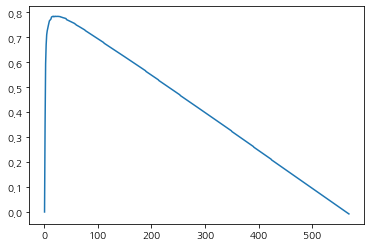

In [15]:
plt.plot(log_num,log_modularity)

##### 클러스터링 수행

In [16]:
#클러스터가 n개인 그래프 생성
n=log_num[max_m_idx]
clusters = find_cluster(n)
#각 클러스터의 사이즈 확인
size = [len(i) for i in clusters]
print(size)

[84, 61, 47, 42, 41, 34, 33, 30, 26, 24, 22, 20, 20, 19, 15, 11, 10, 8, 8, 8, 6]


In [17]:
print(clusters[1])

{'윤호중 의원', '공급량', '혼선', '지적', '임대차보호법', '적용', '리모델링 매입임대', '상가시장', '여론조사기관', '더불어민주당', '임대차', '이 시점', '공급불안', '정책남발', '축조심사', '소급', '전방위', '임대차법', '전세물량', '결과', '민간임대주택', '전세기간 연장', '3+3 개정안', '계약의 자유', '전월세상한제', '부동산대책', '설문조사', '3달', '혼란', '계약갱신청구권', '월세시장', '월세 전환', '7월 말', '사회적 연대', '사회적시장경제질서', '사회적 시장경제질서', '사회적 유대감', '수급불균형', '2015년 9·2 대책', '수도권 주민', '3개월', '월세전환', '국민의 재산권', '전세 물량 부족', '제도 변경', '문의', '부동산시장 과열', '전문가', '정부여당', '위헌 소지', '분쟁', '꼼수', '사업', '재산권 침해', '연대', '후속 대책', '전통적 전세대책', '세 달', '국민 기본권', '7월 31일', '임대료 증액'}


- 군집 수 cutoff using Entropy?? (ranyi disparity)

In [18]:
import math

normal_size = []
total = sum(size)
for i in size:
    normal_size.append(i/total)

w=[]
for i in normal_size:
    w.append(i*math.log(i))

math.exp(-sum(w))  # 17개 이하인 군집은 버리기?? (정확한 해석법은 잘모름)

16.752768048320377

##### 클러스터별 SPO 리스트업

In [19]:
#전체 그래프의 엣지리스트
edgelist = nx.get_edge_attributes(GC,'verb')

In [20]:
#클러스터별 SPO 추출
spolist = {}
for k in range(len(clusters)):
    nodepair = []
    for i in clusters[k]:
        for j in clusters[k]:
            a = (i,j)
            nodepair.append(a)
    spo = {}
    for i in nodepair:
        try:
            spo[i] = edgelist[i]
            
        except KeyError:
            continue
    spolist[k] = spo

In [21]:
spolist

{0: {('새로운 대책', '정부'): '어렵다',
  ('새로운 대책', '매매시장 안정대책'): '충돌할 수 있다',
  ('실수요자 보호', '정부'): '단호하다',
  ('시장 존중 대책', '정부'): '마련해야 하다',
  ('대북정책', '정부'): '추진하다',
  ('임대주택 공급', '정부'): '발표하다',
  ('기존대책', '새로운 대책'): '충돌하다',
  ('목적지', '오류'): '멀어지다',
  ('투기세력', '정부'): '규제하다',
  ('임대주택', '로드맵'): '공급하다',
  ('전세자금대출증가', '원인'): '명확하지 않다',
  ('공급 확대', '정부'): '고려하다',
  ('야당', '홍남기 전세 난민'): '지렛대 삼다',
  ('야당', '부동산정책'): '비판하다',
  ('주거안정', '정부'): '위하다',
  ('주거안정', '실수요자'): '기대하다',
  ('주택가격 안정', '정부'): '의무다',
  ('의지', '실수요자보호'): '단호하다',
  ('의지', '투기억제'): '단호하다',
  ('오류', '정부'): '인정하지 않다',
  ('기존정책 방향성', '정부'): '유지하다',
  ('시장불안정', '정부'): '대책 세우다',
  ('대책 마련', '정부'): '고심하다',
  ('해법', '정부'): '고민하다',
  ('해법', '분노'): '확산하다',
  ('저금리 원인', '정부'): '주장하다',
  ('전세시장 안정', '정부'): '위하다',
  ('취약계층 수급', '정부'): '지원하다',
  ('전월세 대란 대책', '정부'): '고민하다',
  ('재건축 규제', '정부'): '시행하다',
  ('투기억제', '정부'): '단호하다',
  ('부작용', '국민들 신음'): '소급적용되다',
  ('부작용', '다른 곳'): '있다',
  ('부작용', '정부'): '보완하다',
  ('부동산매매 수익', '정부'): '낮출수밖에없다',
  ('금리

In [22]:
# 클러스터별 SPO 개수
[len(spolist[i]) for i in range(len(spolist))]

[84, 66, 51, 42, 43, 34, 32, 30, 25, 24, 21, 20, 19, 18, 14, 10, 9, 7, 7, 7, 5]

In [23]:
#추출된 SPO리스트에서 클러스터별 명사 개수 확인하여 대조
nounlist = []
for i in range(len(spolist)):
    keys = list(spolist[i].keys())
    nouns = []
    for i in keys:
        nouns.append(i[0])
        nouns.append(i[1])
    nouns = set(nouns)
    nounlist.append(nouns)

In [24]:
print([len(nounlist[i]) for i in range(len(nounlist))]==size) 

True


##### Clustering 결과로 추출된 군집을 Graph 형태로 list에 담음

In [25]:
G_list = []

for i in range(len(clusters)):
    cluster_num = i
    G = nx.Graph()
    G.add_nodes_from(nounlist[cluster_num])

    nodes = list(spolist[cluster_num].keys())
    edges = list(spolist[cluster_num].values())

    for j in range(len(nodes)):
        G.add_edges_from([(nodes[j][0], nodes[j][1], {'verb':edges[j]})])
        
    G_list.append(G)

#####  클러스터 넘버 DB에 적재

In [26]:
import psycopg2 as pg2

In [29]:
conn = pg2.connect("dbname='kg_news' user='consulting' port='15432' host='192.168.0.68'")
curs = conn.cursor()

In [28]:
query = 'set graph_path = realestate_news_v3'
curs.execute(query)

for i, g in enumerate(G_list):
    nouns = list(g.nodes())
    query = "match (n:noun) where n.word in " + str(nouns) + " set n.gn_num = " + str(i)
    curs.execute(query)

conn.commit()
curs.close()
conn.close()

In [ ]:
[84, 61, 47, 42, 41, 34, 33, 30, 26, 24, 22, 20, 20, 19, 15, 11, 10, 8, 8, 8, 6]

In [30]:
query = 'set graph_path = realestate_news_v3'
curs.execute(query)
aa = []
for i, g in enumerate(G_list):
    nouns = list(g.nodes())
    query = "match (n:noun) where n.gn_num = " + str(i) + "return count(n)"
    curs.execute(query)
    n = curs.fetchall()
    aa.append(n)

conn.commit()
curs.close()
conn.close()

aa

[[(84,)],
 [(61,)],
 [(47,)],
 [(42,)],
 [(41,)],
 [(34,)],
 [(33,)],
 [(30,)],
 [(26,)],
 [(24,)],
 [(22,)],
 [(20,)],
 [(20,)],
 [(19,)],
 [(15,)],
 [(11,)],
 [(10,)],
 [(8,)],
 [(8,)],
 [(8,)],
 [(6,)]]

#### 주요 SPO 추출

##### 군집 별 중심 노드 추출

In [26]:
def extract_cent_node(G_list, threshold = 0.5):
    cent_node_list = []
    
    for i,sub_graph in enumerate(G_list):
        # 군집의 노드갯수가 20이상일 경우
        if len(sub_graph.nodes()) >= 20:
            dict_DC = nx.degree_centrality(sub_graph)
            max_DC = max(dict_DC.values())
            selected_DC = dict(filter(lambda dict_DC:dict_DC[1]>max_DC*threshold, dict_DC.items()))

            cent_node_list.append(selected_DC)
            
        # 군집의 노드갯수가 20미만일 경우
        else:
            dict_DC = nx.degree_centrality(sub_graph)
            max_DC = max(dict_DC.values())
            selected_DC = dict(filter(lambda dict_DC:dict_DC[1]==max_DC, dict_DC.items()))
            
            cent_node_list.append(selected_DC)
    return cent_node_list

In [28]:
cent_node_list = extract_cent_node(G_list,0.6)
cent_node_list

[{'정부': 0.6385542168674699},
 {'임대차법': 0.6166666666666667},
 {'전셋값': 0.6739130434782609},
 {'전세난': 0.6341463414634146},
 {'시장': 0.275},
 {'전세': 0.30303030303030304, '임차인': 0.24242424242424243},
 {'공공임대': 0.34375, '대책': 0.25},
 {'집주인': 0.6551724137931034},
 {'전세대출': 0.64},
 {'매매가': 0.21739130434782608, '전세가격': 0.34782608695652173},
 {'국토교통부': 0.5714285714285714},
 {'김현미 장관': 0.3157894736842105, '임대차신고제': 0.3157894736842105},
 {'전세수요': 0.3157894736842105, '수요': 0.21052631578947367},
 {'세입자': 0.7222222222222222},
 {'임대료': 0.3571428571428571},
 {'국민': 0.6000000000000001},
 {'전세시장': 0.7777777777777777},
 {'서울 아파트 누적 변동률': 0.5714285714285714},
 {'디딤돌대출': 0.5714285714285714},
 {'금융위원회': 0.42857142857142855, '임대주택공급': 0.42857142857142855},
 {'주택 공급': 0.6000000000000001}]

##### 워드카운트 방식

In [31]:
# Load pickle
with open("../../jh_jo/RnD3_TextGraph/node_weight4","rb") as fr:
    node_weight = pickle.load(fr)

In [32]:
# G_list 크기 만큼 for loop
for i, g in enumerate(G_list):
    cluster_num = i
    cen_node = cent_node_list[i]
    
    print('cluster', cluster_num)
    
    # 각 군집의 중심 노드와 중심 노드의 이웃노드 추출
    for cen in cen_node:
        print()
        print('** center node :', cen,'**')
        tmp_neighbor_list = list(g.neighbors(cen))
        
        # 이웃노드의 wordcount값 추출
        tmp_dict = {}
        for neighbor in tmp_neighbor_list:
            if neighbor in node_weight.keys():
                tmp_dict[neighbor] = node_weight[neighbor]
                    
        tmp_dict = sorted(tmp_dict.items(), key=lambda item: item[1], reverse=True)
        [print(dic) for dic in tmp_dict]
        
    print('='*80)
    print()

cluster 0

** center node : 정부 **
('전세난 안정', 152.5)
('전세시장안정', 131.67)
('전세시장 안정', 131.67)
('전세 대책 발표', 115.0)
('임대주택 공급', 102.33)
('임대인 보호', 99.0)
('새로운 대책', 73.0)
('시장 존중 대책', 54.67)
('부동산시장 안정', 54.67)
('주택담보대출', 54.0)
('시장 수급', 52.5)
('주택가격 안정', 47.33)
('대출 규제', 45.5)
('시장불안정', 43.67)
('전월세 대란 대책', 42.0)
('추가대책', 42.0)
('대책 마련', 39.5)
('대책의 여지', 37.5)
('주택 및 지역 개발부', 31.33)
('공급 확대', 31.0)
('부동산정책', 29.5)
('신규대책 발표', 28.0)
('금리탓', 27.0)
('부동산매매 수익', 26.33)
('지분적립형 분양주택', 24.5)
('주거안정', 21.0)
('기존정책', 16.0)
('저금리 원인', 12.5)
('기존 정책 추진', 12.0)
('대북정책', 11.5)
('기존정책 방향성', 11.0)
('서민불안', 9.5)
('취약계층 수급', 8.0)
('재건축 규제', 7.0)
('공시지가', 7.0)
('실수요자 보호', 7.0)
('실수요자', 6.5)
('3+3년 개정안', 6.0)
('표준임대료 도입', 5.33)
('로드맵', 4.0)
('부작용', 4.0)
('인구 감소로 따른 가구 분화', 4.0)
('대응방안 마련', 3.67)
('투기억제', 3.0)
('전 정권', 2.0)
('영향 분석', 2.0)
('투기세력', 2.0)
('해법', 2.0)
('오류', 2.0)
('관계부처간 협의', 1.67)
('검찰개혁', 1.0)
('언론', 1.0)
('원희룡 제주지사', 1.0)

cluster 1

** center node : 임대차법 **
('전세물량', 145.0)
('전세기간 연장', 93.33)


##### Edge Betweenness Centrality 방식

In [33]:
# G_list 크기 만큼 for loop
for i, g in enumerate(G_list):
    cluster_num = i
    cen_node = cent_node_list[i]
    tmp_ebc = nx.edge_betweenness_centrality(G_list[i])
    print('cluster', cluster_num)
    print()
    
    for cen in cen_node:
        print('** center node :', cen,'**')
        # Betweenness centrality 실행한 dict에서 중심 노드와 연결된 Edge만 필터
        old_ebc_filter = dict(filter(lambda elem: cen in elem[0] , tmp_ebc.items()))
        new_ebc_filter = {}
        
        """
        tmp_ebc의 Key가 Tuple형태로 되어 있어 중심노드를 제외한 {노드명: E_B_C값}으로 변환
        ex: {('정부', '투기억제'):0.119} ->  {'투기억제': 0.119}
        """
        for old_key in old_ebc_filter:
            new_key = list(old_key)
#             print(new_key, old_key)
            new_key.remove(cen)
            new_ebc_filter[new_key[0]] = old_ebc_filter[old_key]

        del(old_ebc_filter)
        # Betweenness centrality 값이 높은 순서대로 정렬
        new_ebc_filter = sorted(new_ebc_filter.items(), key=lambda item: item[1], reverse=True)
        [print(ebc) for ebc in new_ebc_filter]
        print()
            
    print('='*80)
    print()

cluster 0

** center node : 정부 **
('지분적립형 분양주택', 0.09179575444635685)
('부동산정책', 0.09179575444635685)
('전 정권', 0.09179575444635685)
('투기억제', 0.09179575444635685)
('로드맵', 0.06970740103270223)
('3+3년 개정안', 0.06970740103270223)
('새로운 대책', 0.06970740103270223)
('부작용', 0.06970740103270223)
('추가대책', 0.06970740103270223)
('기존정책', 0.04704532415375788)
('해법', 0.04704532415375788)
('주택담보대출', 0.04704532415375788)
('부동산시장 안정', 0.04704532415375788)
('주택 및 지역 개발부', 0.04704532415375788)
('오류', 0.04704532415375788)
('시장 수급', 0.04704532415375788)
('실수요자', 0.04647160068846815)
('전세난 안정', 0.023809523809523808)
('언론', 0.023809523809523808)
('검찰개혁', 0.023809523809523808)
('관계부처간 협의', 0.023809523809523808)
('대책 마련', 0.023809523809523808)
('전세 대책 발표', 0.023809523809523808)
('신규대책 발표', 0.023809523809523808)
('시장 존중 대책', 0.023809523809523808)
('대출 규제', 0.023809523809523808)
('기존 정책 추진', 0.023809523809523808)
('전세시장안정', 0.023809523809523808)
('투기세력', 0.023809523809523808)
('표준임대료 도입', 0.023809523809523808)
('저금리

##### NPS distance 방식

In [42]:
#전체 그래프에서 노드간 distance 계산
g = GC.copy()
n = g.number_of_nodes()
w = {u: 0 for u in g.nodes()}
wtot = 0
for (u,v) in g.edges():
    if 'weight' not in g[u][v]:
        g[u][v]['weight'] = 1
    weight = g[u][v]['weight']
    w[u] += weight
    w[v] += weight
    wtot += weight
    if u != v:
        wtot += weight
        
for (u,v) in g.edges():
    if 'distance' not in g[u][v]:
        d = w[u] * w[v] / float(g[u][v]['weight']) / float(wtot)
        g[u][v]['distance'] = d

In [43]:
for i, gg in enumerate(G_list):
    print()
    print('cluster', i,'****************************************')
    cen_node = cent_node_list[i]
    
    for cen in cen_node:
        print()
        print('** center node :', cen,'**')
        tmp_neighbor_list = list(gg.neighbors(cen))
        
        tmp_dict = {}
        for neighbor in tmp_neighbor_list:
            tmp_dict[neighbor] = round(g[cen][neighbor]['distance'],2)
        
        tmp_dict = sorted(tmp_dict.items(), key=lambda item: item[1], reverse=True)
        
        [print(dic) for dic in tmp_dict]
        
    print('='*80)


cluster 0 ****************************************

** center node : 정부 **
('새로운 대책', 0.21)
('지분적립형 분양주택', 0.21)
('실수요자', 0.21)
('로드맵', 0.16)
('3+3년 개정안', 0.16)
('부작용', 0.16)
('부동산정책', 0.16)
('시장 수급', 0.16)
('추가대책', 0.16)
('전 정권', 0.11)
('임대주택 공급', 0.11)
('기존정책', 0.11)
('주거안정', 0.11)
('해법', 0.11)
('주택담보대출', 0.11)
('부동산시장 안정', 0.11)
('주택 및 지역 개발부', 0.11)
('오류', 0.11)
('투기억제', 0.11)
('검찰개혁', 0.05)
('관계부처간 협의', 0.05)
('전세 대책 발표', 0.05)
('시장불안정', 0.05)
('영향 분석', 0.05)
('전세난 안정', 0.05)
('언론', 0.05)
('대책 마련', 0.05)
('신규대책 발표', 0.05)
('시장 존중 대책', 0.05)
('대출 규제', 0.05)
('기존 정책 추진', 0.05)
('전세시장안정', 0.05)
('투기세력', 0.05)
('표준임대료 도입', 0.05)
('저금리 원인', 0.05)
('대응방안 마련', 0.05)
('전세시장 안정', 0.05)
('취약계층 수급', 0.05)
('부동산매매 수익', 0.05)
('기존정책 방향성', 0.05)
('대책의 여지', 0.05)
('금리탓', 0.05)
('재건축 규제', 0.05)
('공시지가', 0.05)
('서민불안', 0.05)
('공급 확대', 0.05)
('대북정책', 0.05)
('원희룡 제주지사', 0.05)
('인구 감소로 따른 가구 분화', 0.05)
('실수요자 보호', 0.05)
('임대인 보호', 0.05)
('전월세 대란 대책', 0.05)
('주택가격 안정', 0.05)

cluster 1 **************

In [54]:
spolist

{0: {('지분적립형 분양주택', '공급 모델'): '기대되다',
  ('지분적립형 분양주택', '2023년'): '가능하다',
  ('지분적립형 분양주택', '도심'): '적용되다',
  ('로드맵', '임대주택'): '공급하다',
  ('의지', '실수요자보호'): '단호하다',
  ('의지', '부동산시장안정'): '단호하다',
  ('의지', '투기억제'): '단호하다',
  ('세대분할', '원인'): '설명하다',
  ('검찰개혁', '정부'): '추진하다',
  ('관계부처간 협의', '정부'): '진행하다',
  ('새로운 대책', '기존대책'): '충돌하다',
  ('새로운 대책', '매매시장 안정대책'): '충돌할 수 있다',
  ('새로운 대책', '정부'): '어렵다',
  ('홍남기 전세 난민', '야당'): '지렛대 삼다',
  ('기존정책', '응답자 38.8%'): '유지하다',
  ('비난여론', '3+3년 개정안'): '나타나다',
  ('부작용', '국민들 신음'): '소급적용되다',
  ('야당', '부동산정책'): '비판하다',
  ('전세 대책 발표', '정부'): '계획이다',
  ('27.40%', '주택담보대출'): '증가하다',
  ('부동산정책', '집값상승'): '응답하다',
  ('원인', '전세자금대출증가'): '명확하지 않다',
  ('다른 곳', '부작용'): '있다',
  ('전 정권', '원인'): '설명하다',
  ('전 정권', '정부'): '언급하다',
  ('해법', '분노'): '확산하다',
  ('홍남기 부총리', '추가대책'): '고민하다',
  ('임대주택 공급', '정부'): '발표하다',
  ('목적지', '오류'): '멀어지다',
  ('부동산 시정 안정', '시장 수급'): '만들다',
  ('신설', '주택 및 지역 개발부'): '검토하다',
  ('실수요자', '주거안정'): '기대하다',
  ('실수요자', '분통'): '터트리다',
  ('자체수급', '부동산시장 안정'

#### 시각화

- 전체그래프

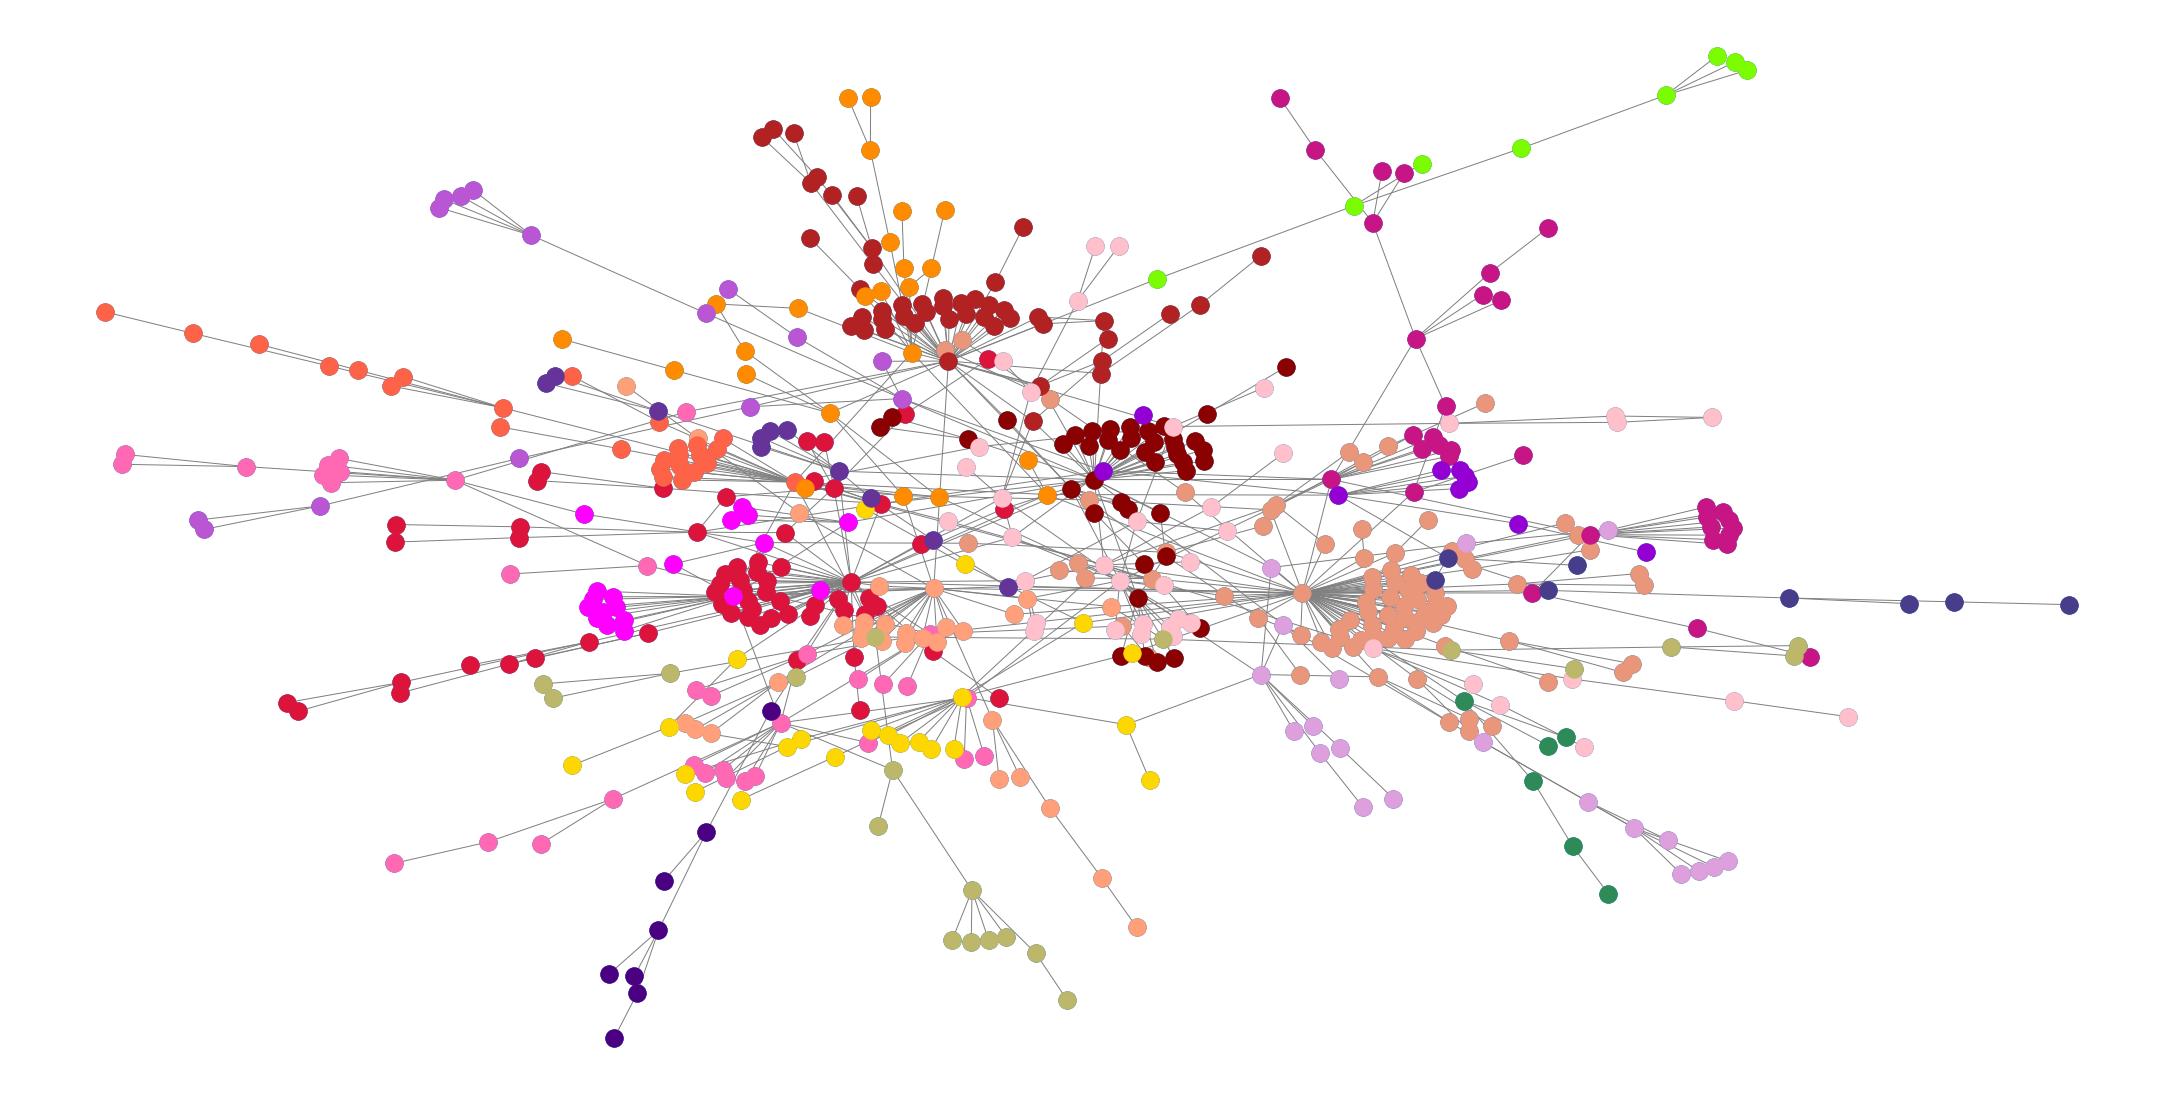

In [20]:
#클러스터가 n개인 그래프 시각
cor_list=['r','g','b','c','m','y','orange','purple','gray','saddlebrown']
colors = ['#E9967A','#DC143C','#B22222','#8B0000','#FFC0CB','#FF69B4','#C71585','#FFA07A',\
         '#FF6347','#FF8C00','#FFD700','#BDB76B','#DDA0DD','#FF00FF','#BA55D3','#663399','#9400D3',\
         '#4B0082','#483D8B','#7CFC00','#2E8B57','#008000']

#레이아웃
#planar_layout, rescale_layout, fruchterman_reingold_layout, spectral_layout, random_layout, bipartite_layout,
#circular_layout, spring_layout, kamada_kawai_layout

# 전체 그래프 그리기
pos=nx.spring_layout(GC) 
plt.figure(figsize=(30, 15))
# nx.draw(GC, pos, with_labels = True, font_weigth = "bold", font_family=font_name, font_size=5, edge_color='gray')
nx.draw(GC, pos, edge_color='gray')

# 그룹이 n개로 나누어지게 node색 지정
n=len(clusters)
for i in range(n):
    nx.draw_networkx_nodes(GC, pos, nodelist=clusters[i], node_color=colors[i])   

# plt.savefig('total_graph.png')

- 클러스터별

In [45]:
key_edges = {
    0:[('전세시장안정', '정부'),('전월세 대란 대책', '정부'),('전세 대책 발표', '정부')],
    1:[('임대차법', '혼란'),('임대차법', '전월세상한제'),('임대차법', '전세물량'),('임대차법', '계약갱신청구권')],
    2:[('전국', '전셋값'),('가격', '전셋값')],
    3:[('전세난', '여러 요인'),],
    4:[('전세매물', '시장')],
    5:[('전세', '부동산시장')],
    6:[('공공임대', '대책')],
    7:[('불만', '집주인')],
    8:[('전세대출', '전세보증금'),('전세대출', '대출상품'),],
    9:[('전세가격', '서울 외곽'),('경기도', '매매가'),('아파트 매입', '서울 외곽'),('아파트 매입', '경기도')],
    10:[('입장', '국토교통부')],
    11:[('세액공제 확대', '김현미 장관'),('세입자 부담', '세액공제 확대')],
    12:[('전세수요', '매매')],
    13:[('세입자', '갈등')],
    14:[('공시지가 상승', '집값'),('상승', '집값')],
    15:[('부동산문제', '국민')],
    16:[('현재', '전세시장')],
    17:[('임대주택공급', '전세안정대책'),('전세대책', '금융위원회')],
    18:[('전세대란', '2011년')],
    19:[('서민 주택구입', '디딤돌대출')],
    20:[('확대', '주택 공급')]
}

cluster 0


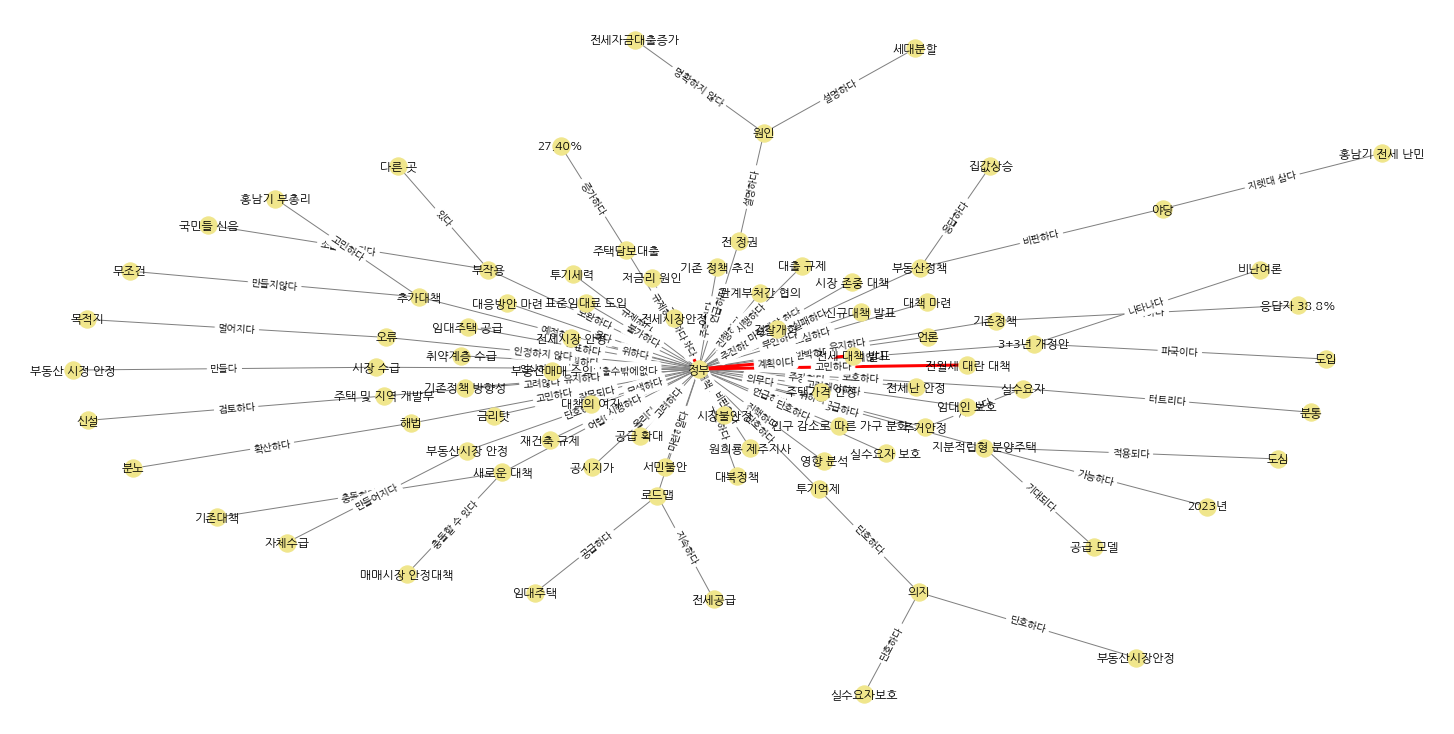

cluster 1


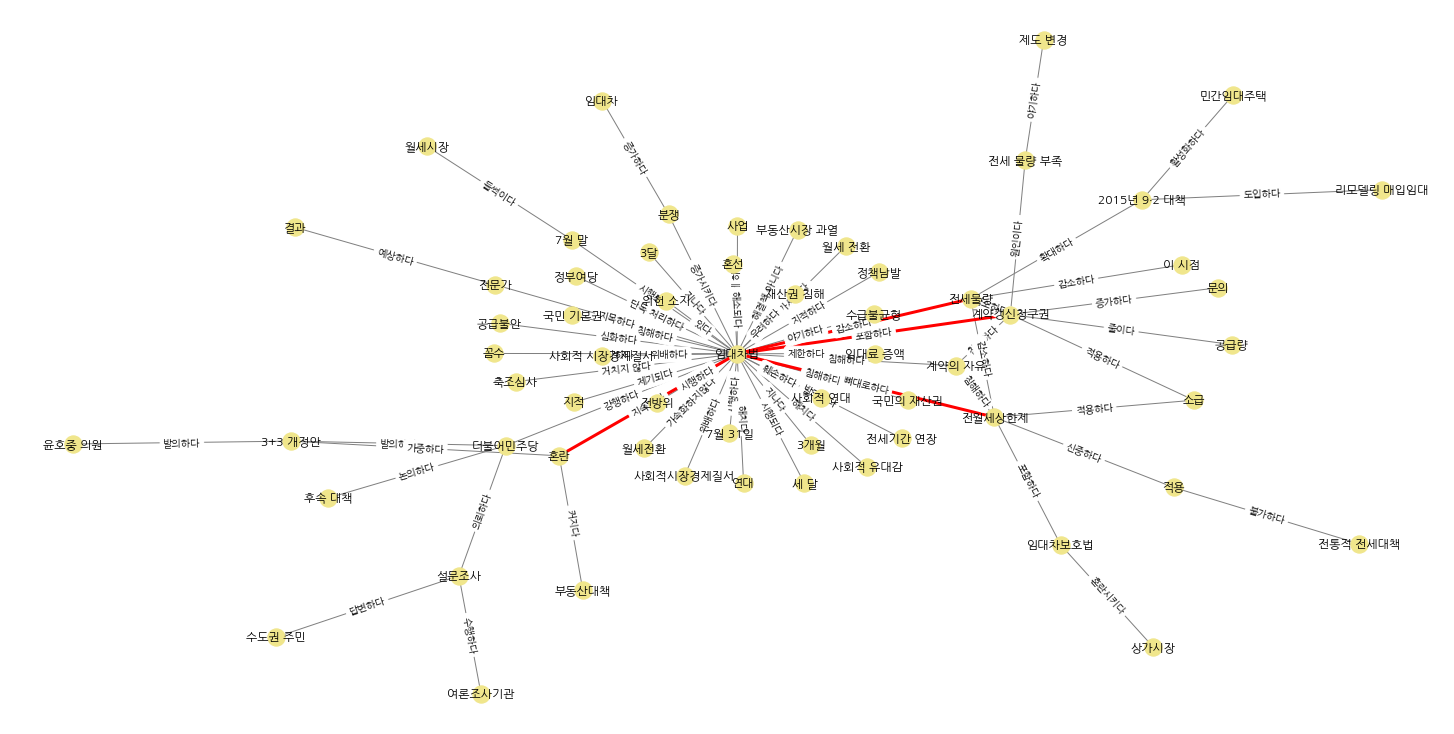

cluster 2


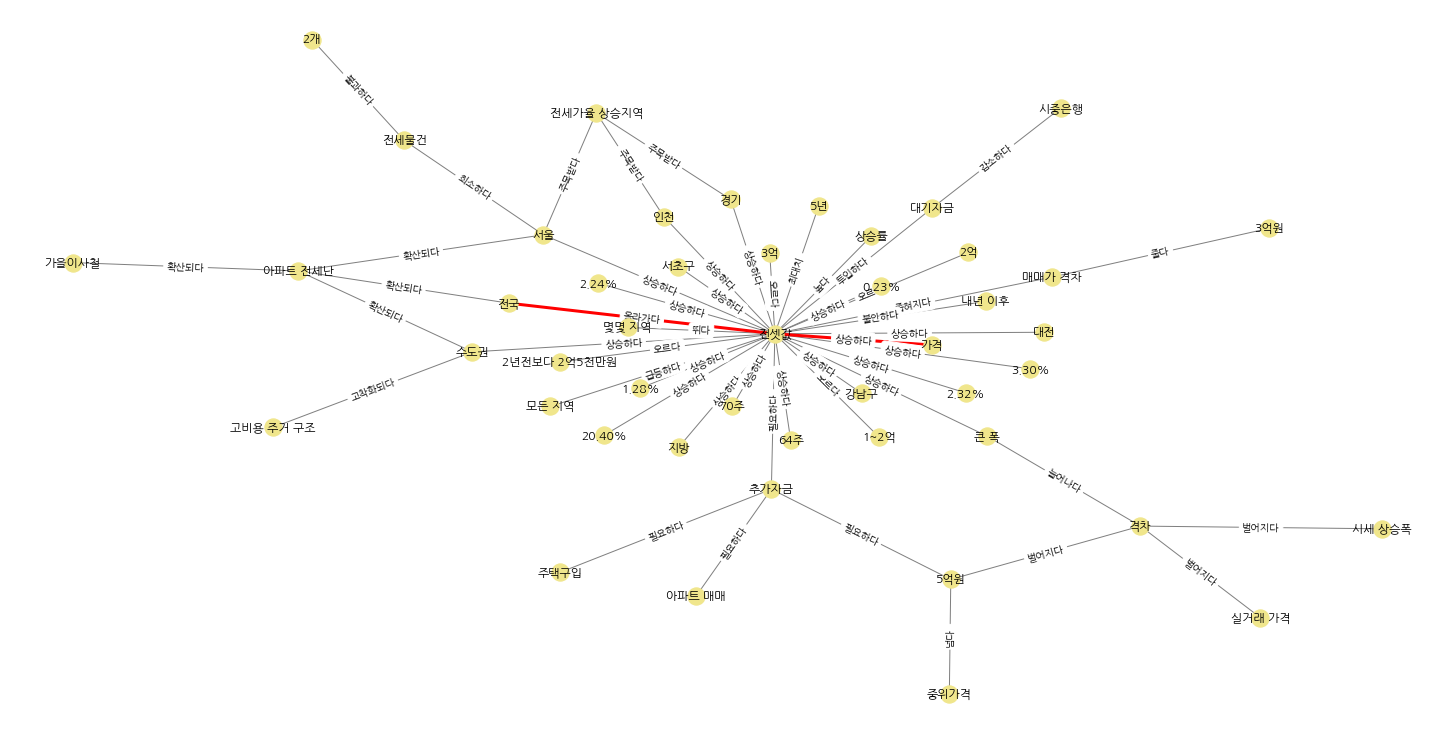

cluster 3


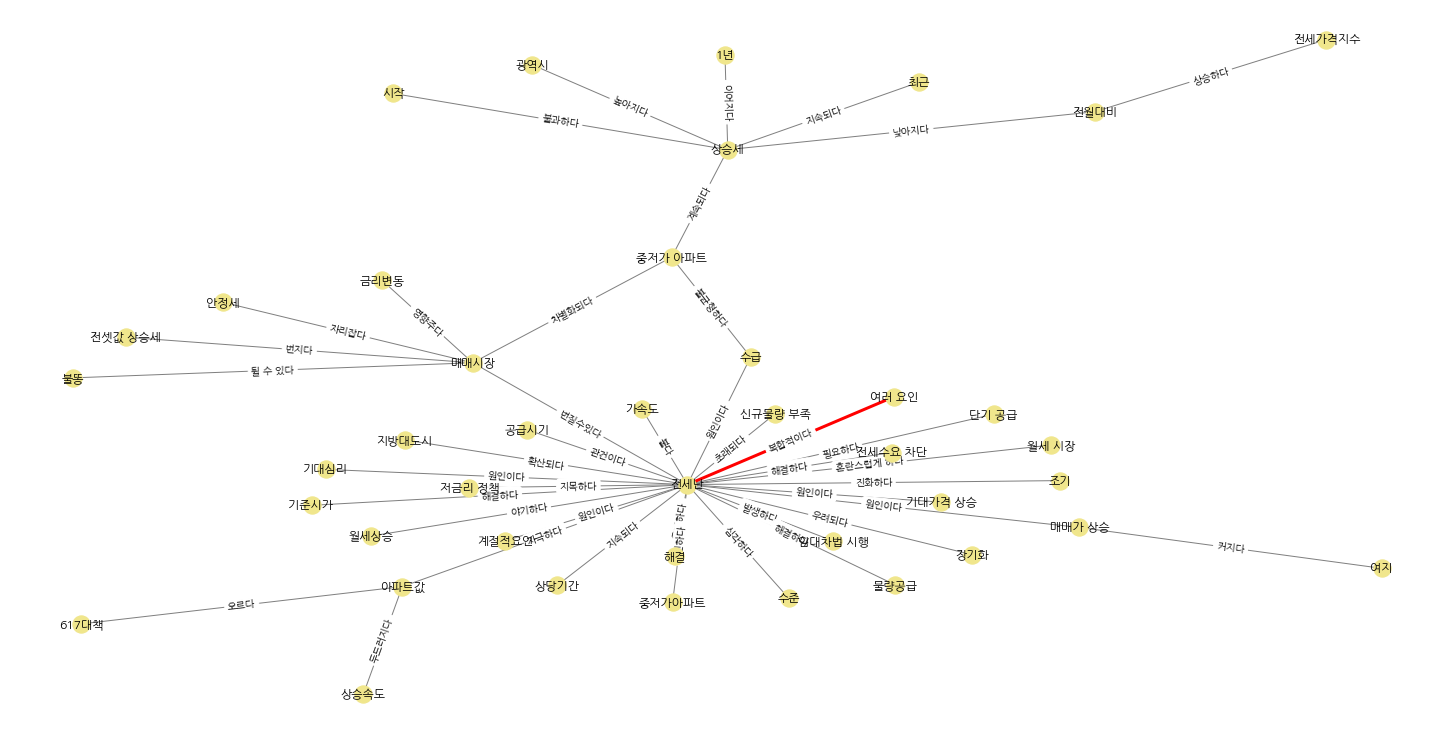

cluster 4


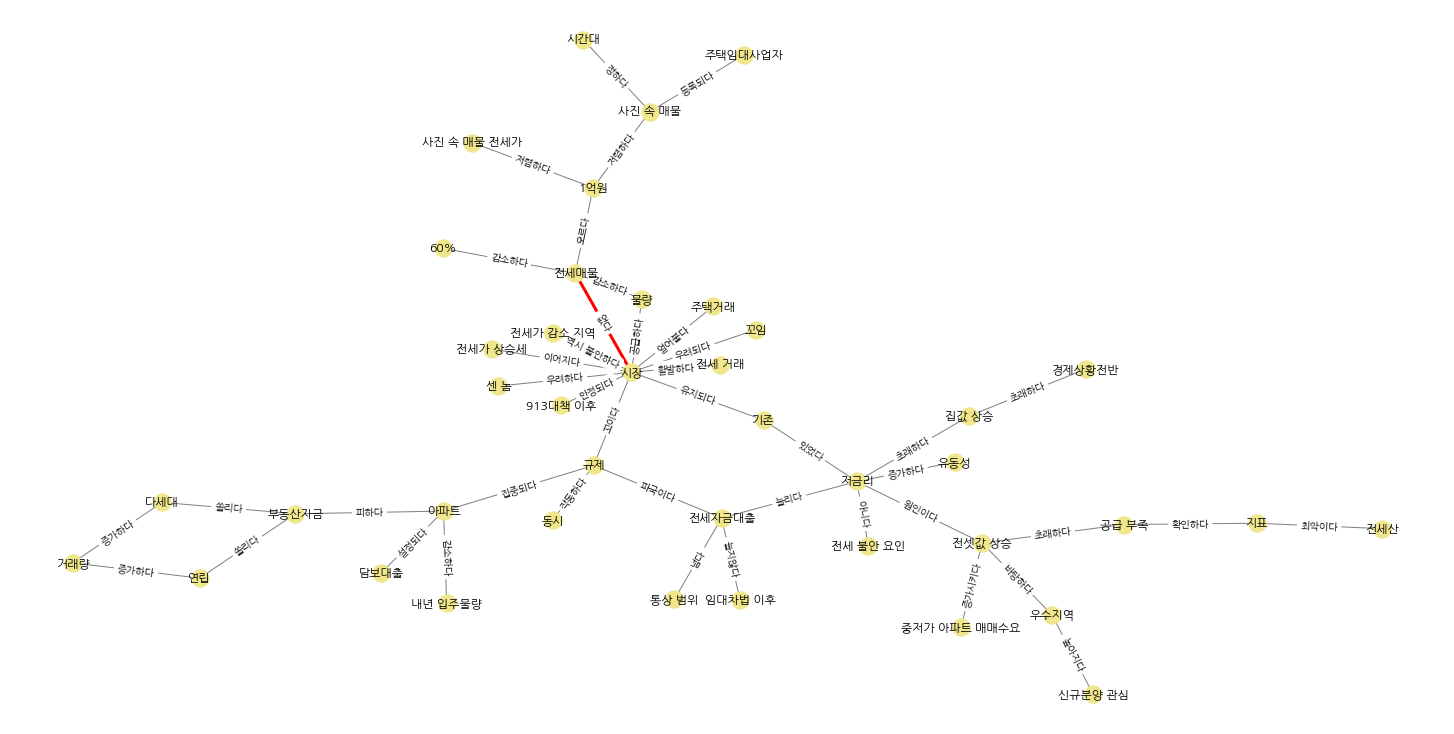

cluster 5


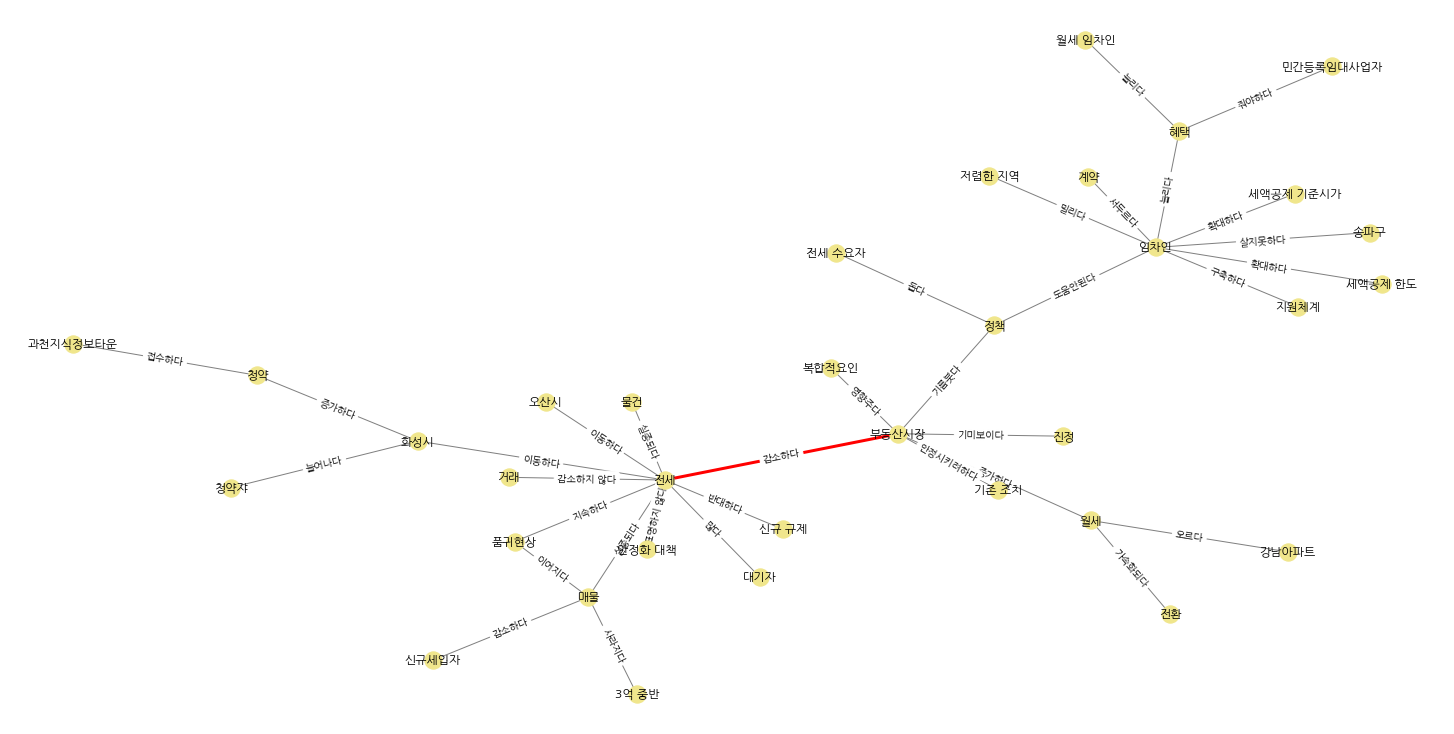

cluster 6


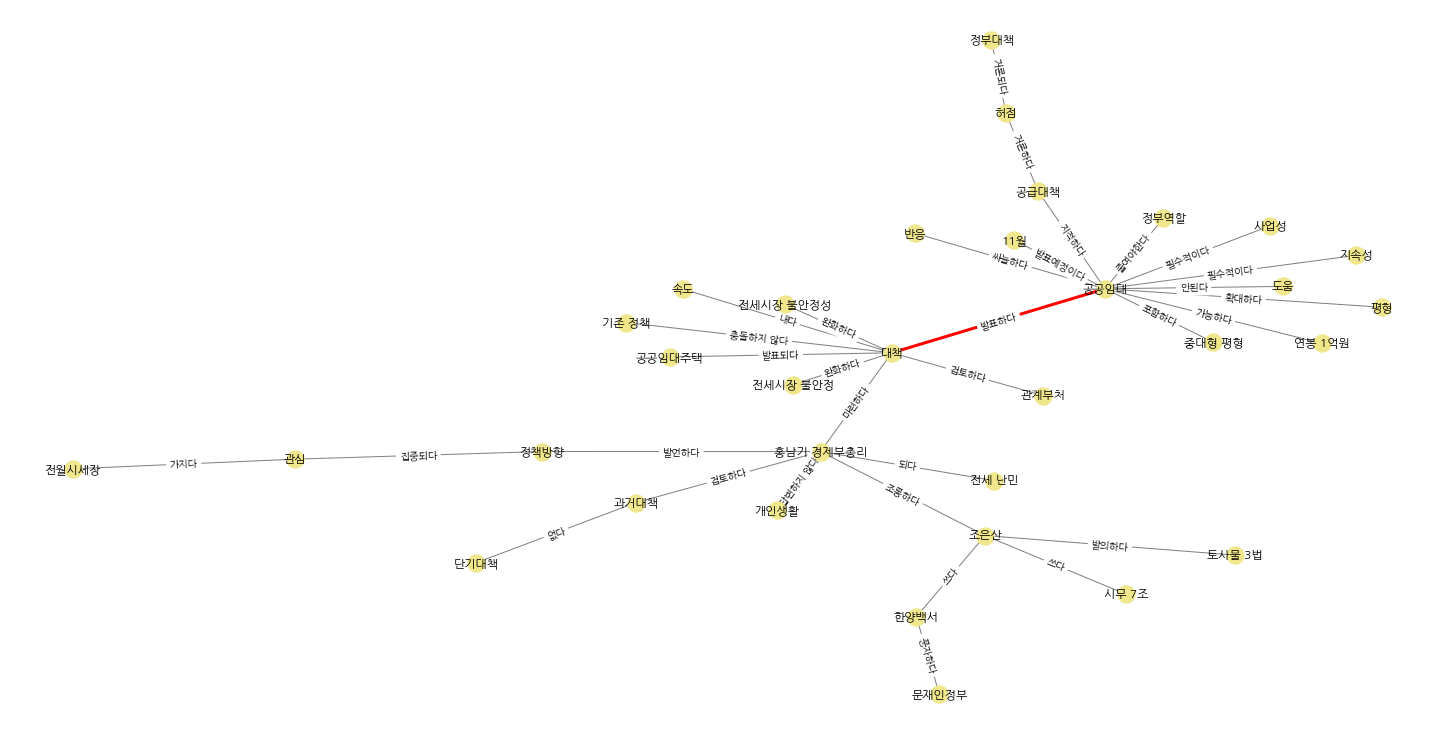

cluster 7


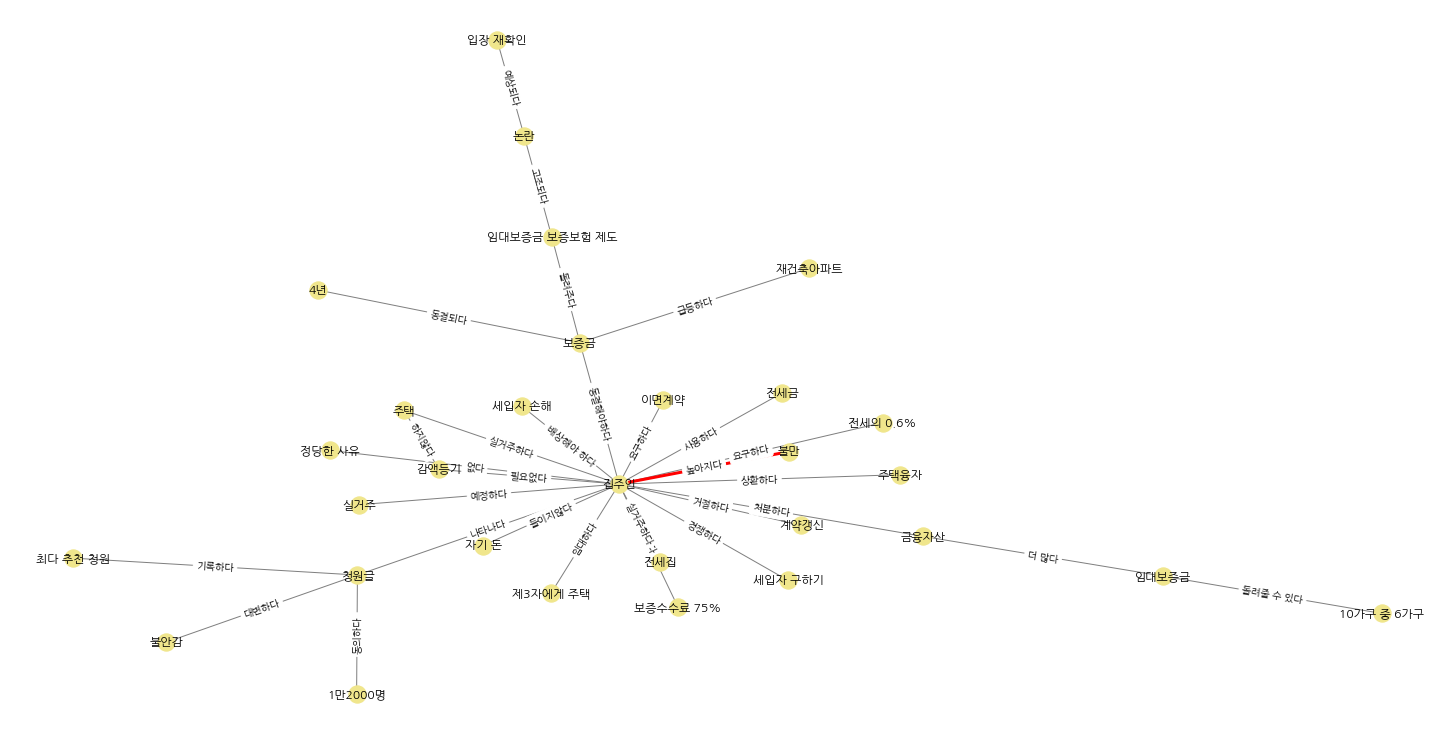

cluster 8


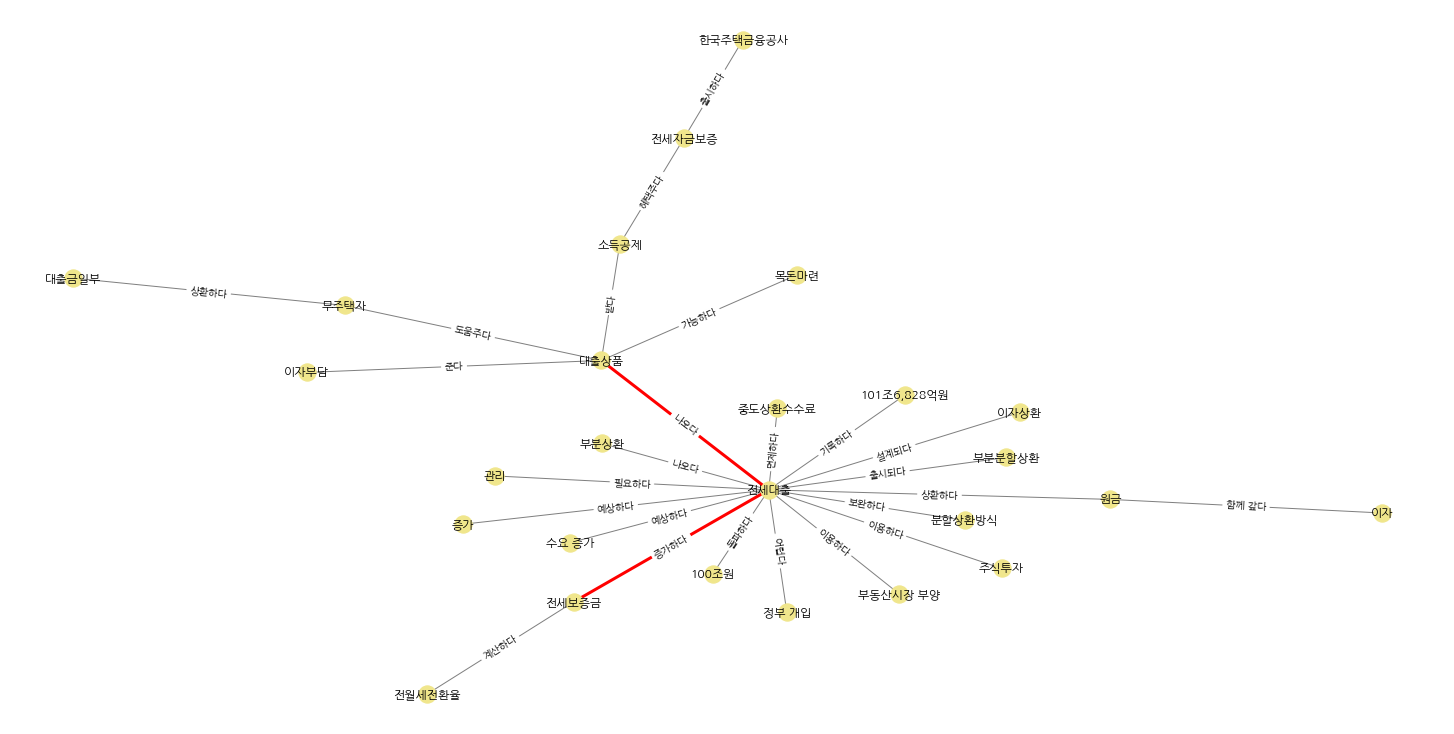

cluster 9


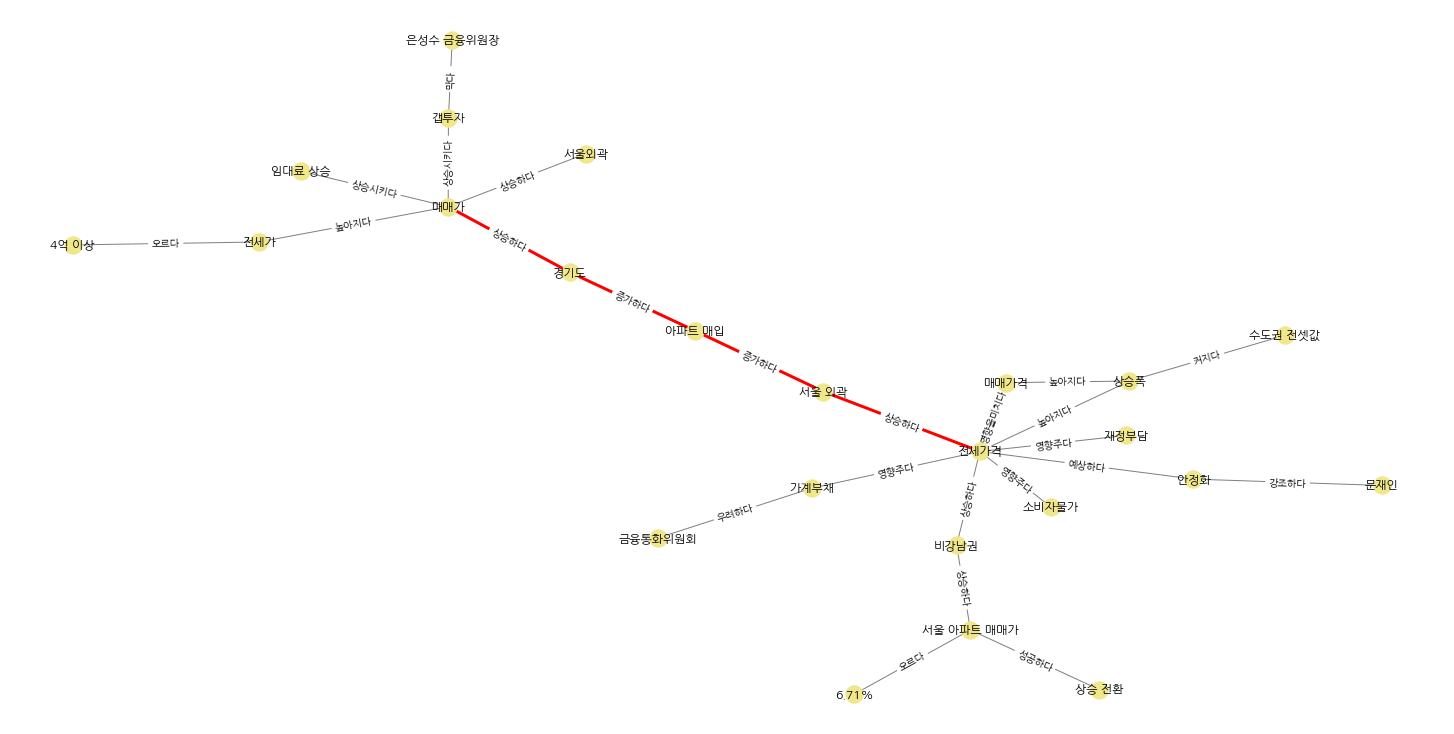

cluster 10


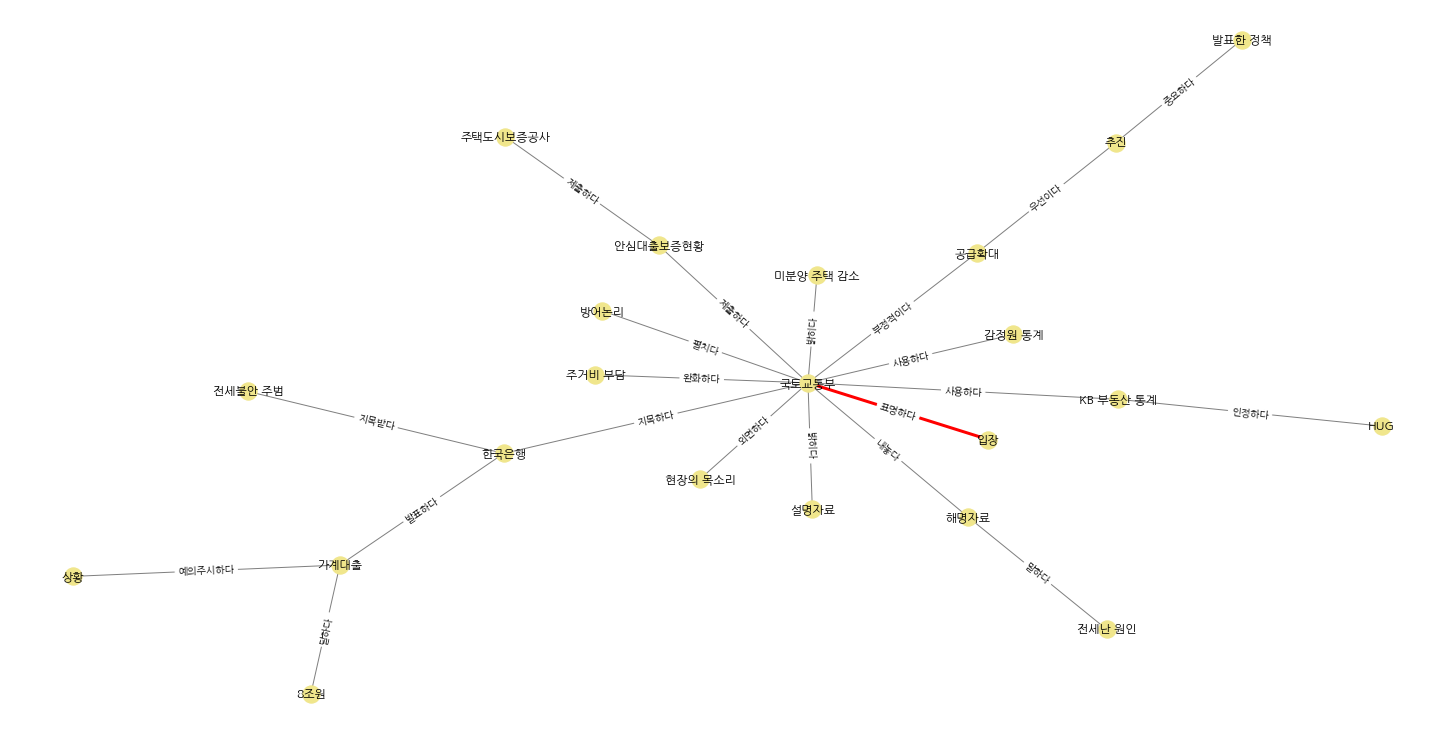

cluster 11


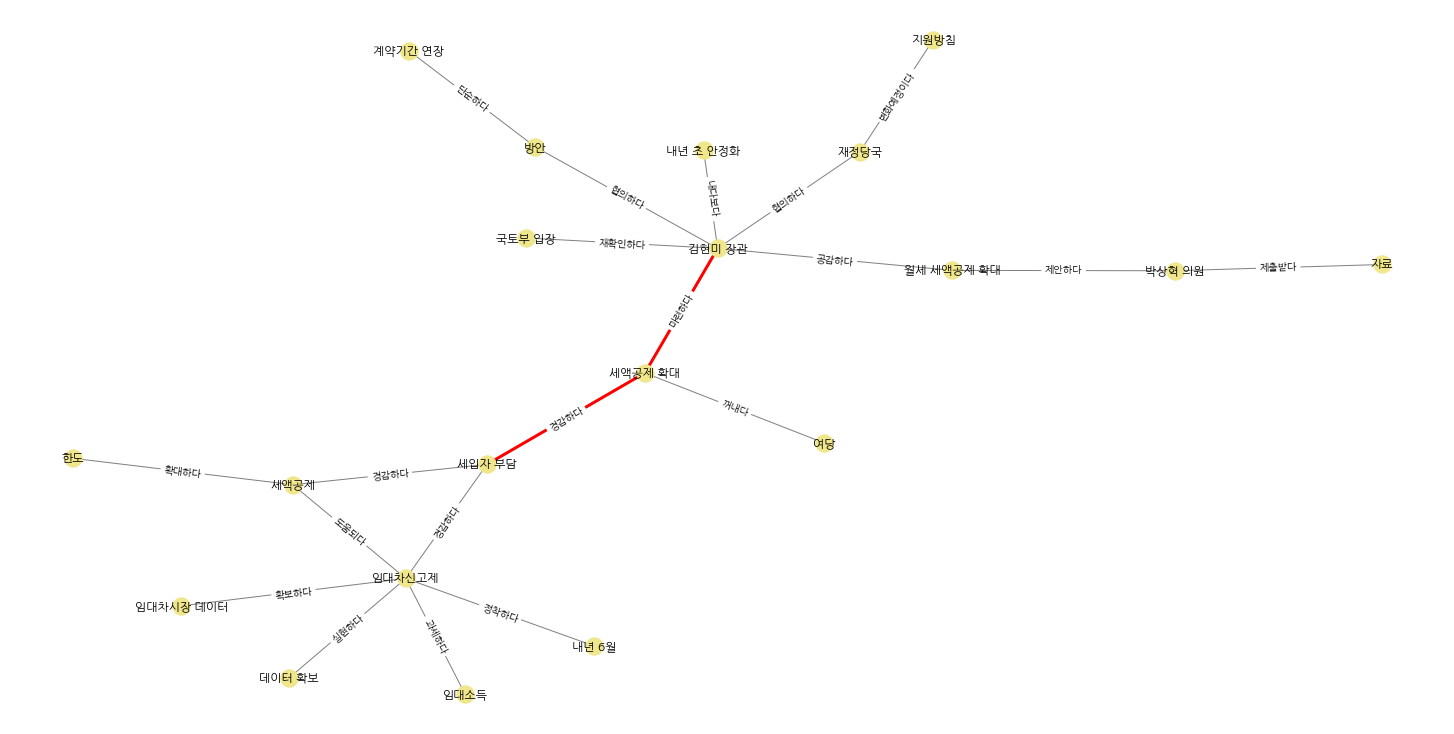

cluster 12


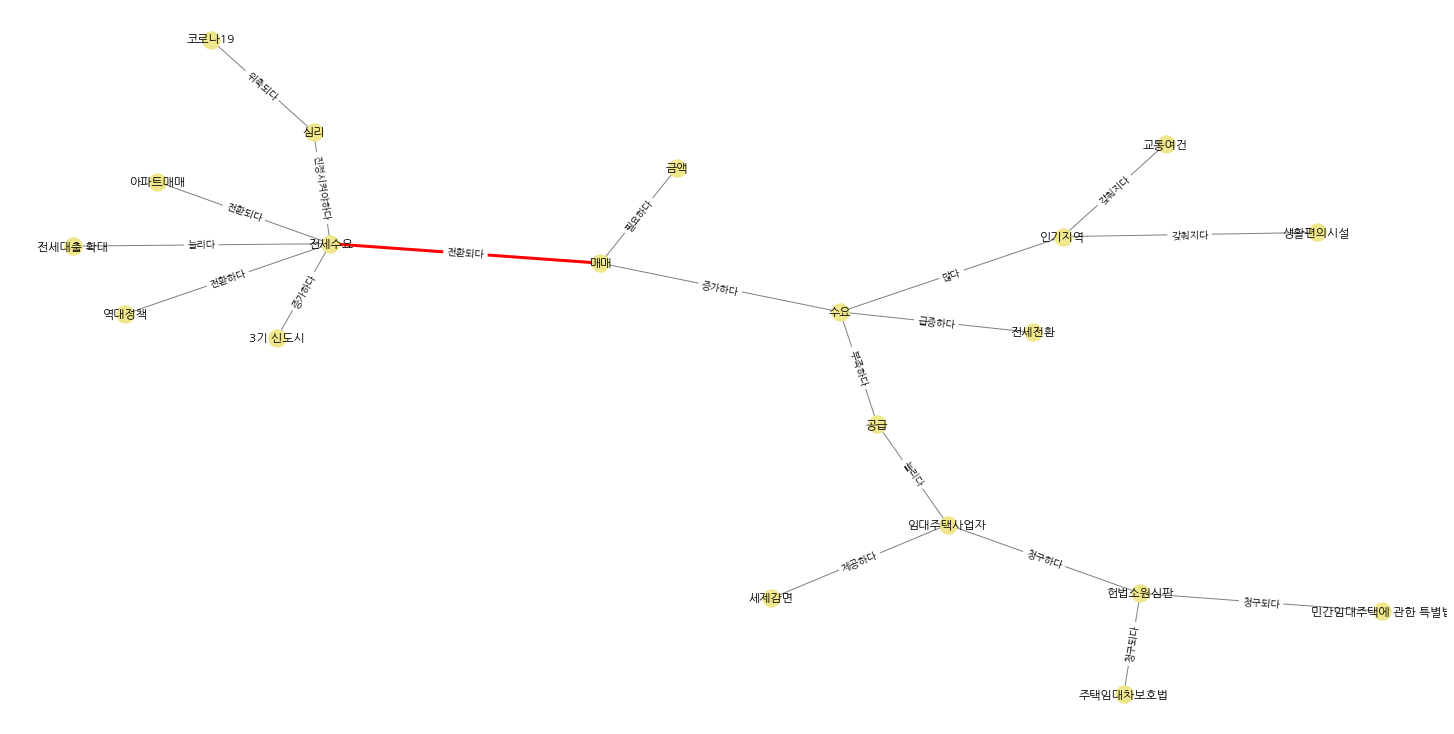

cluster 13


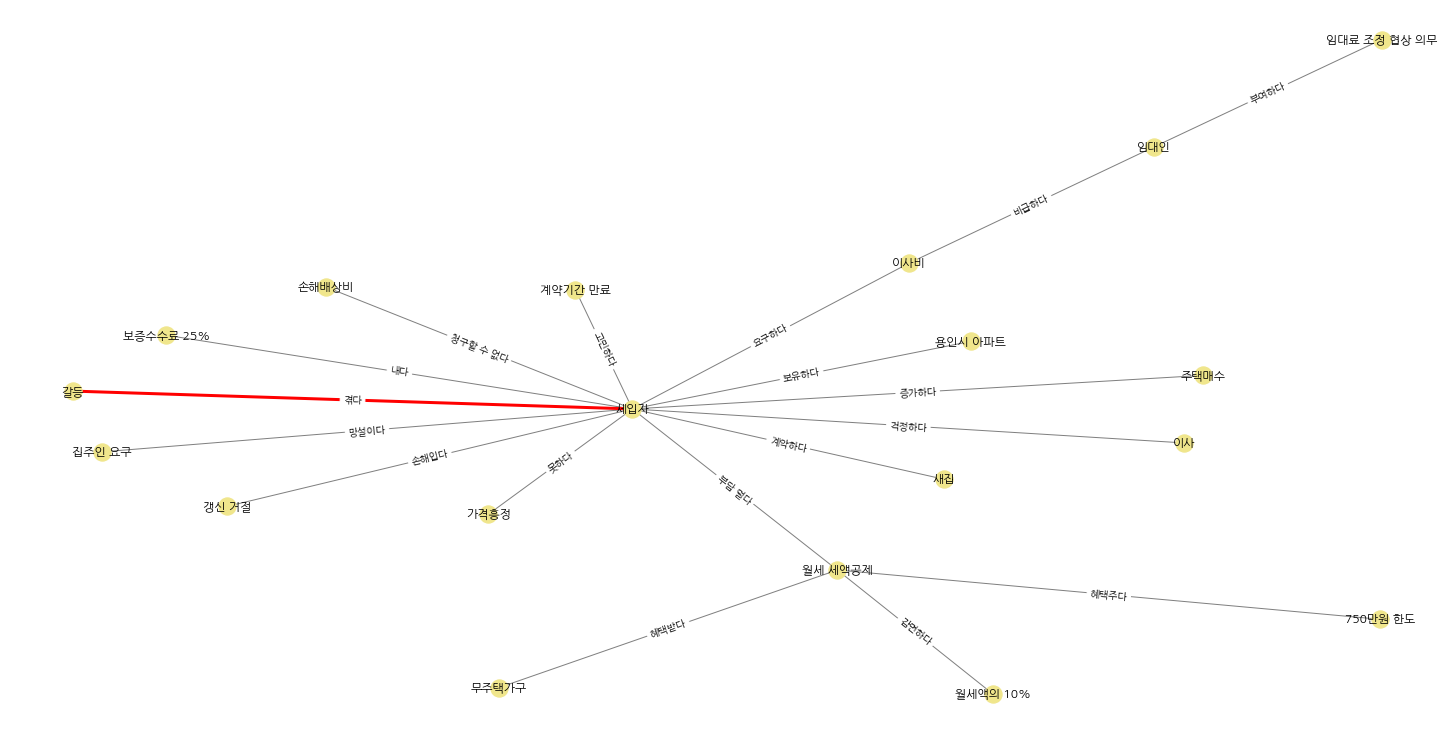

cluster 14


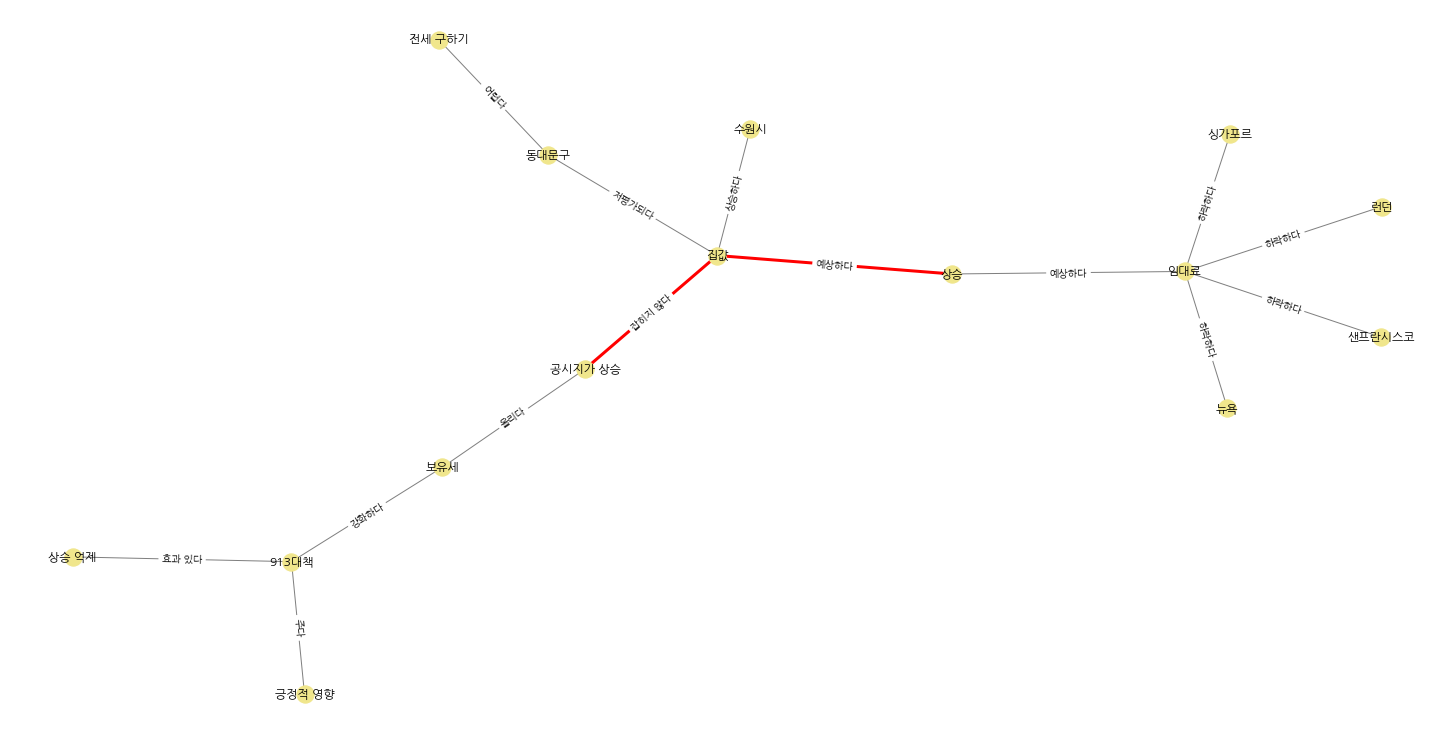

cluster 15


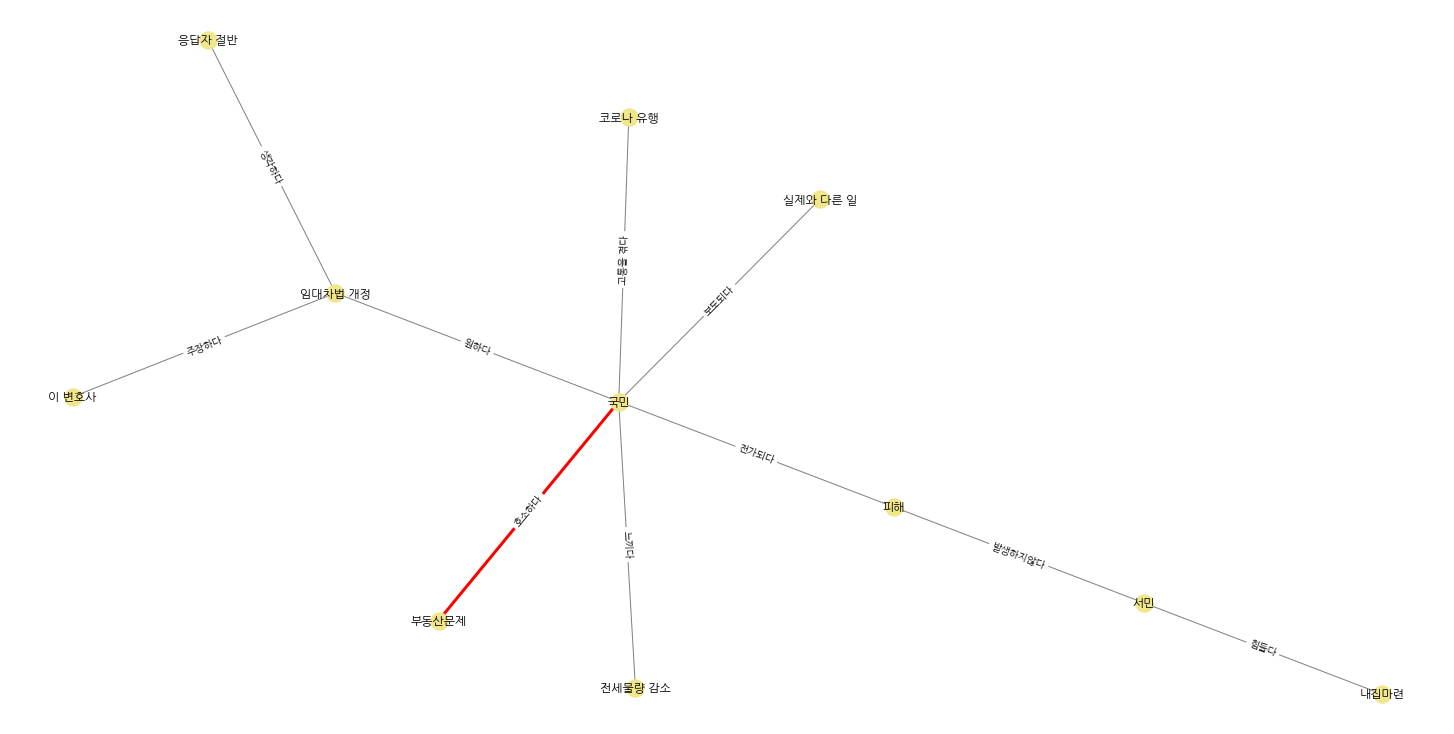

cluster 16


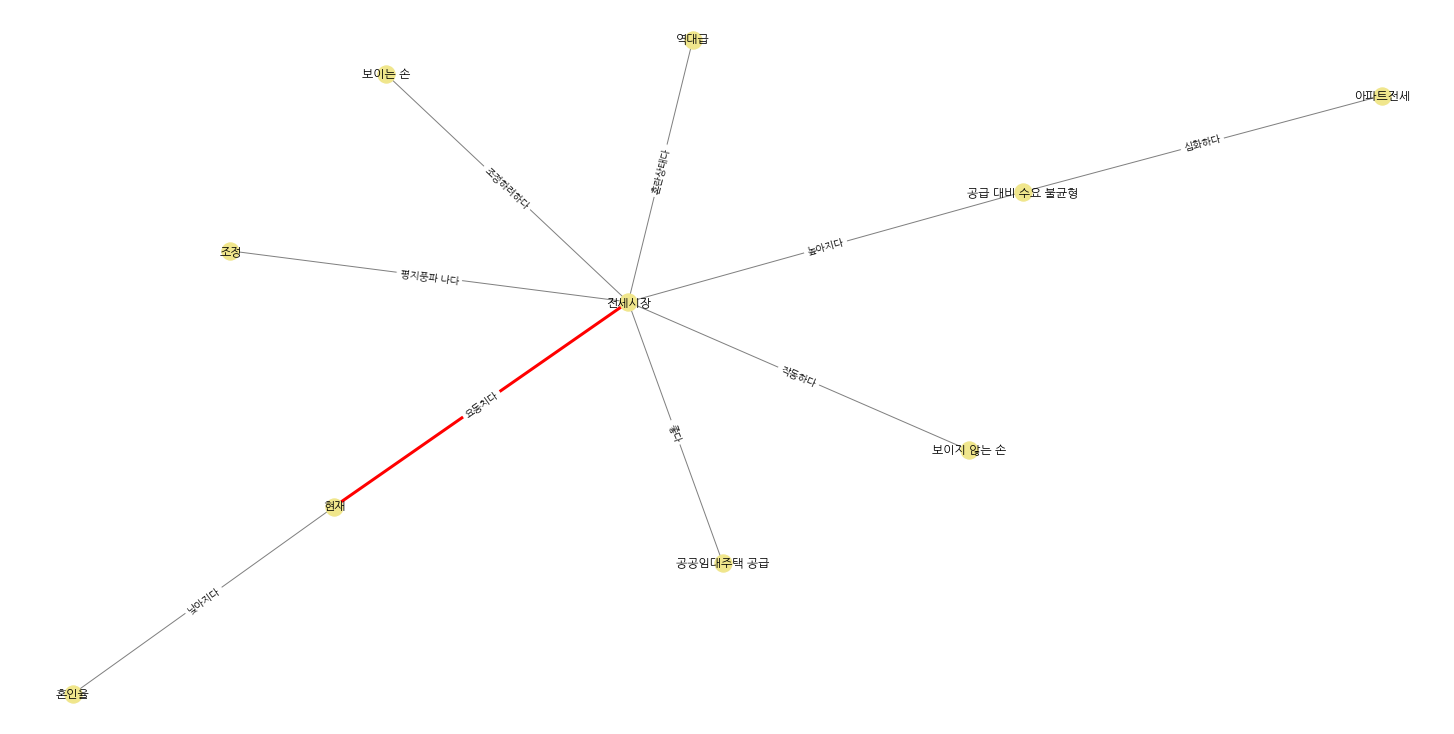

KeyError: '임대주택공급'

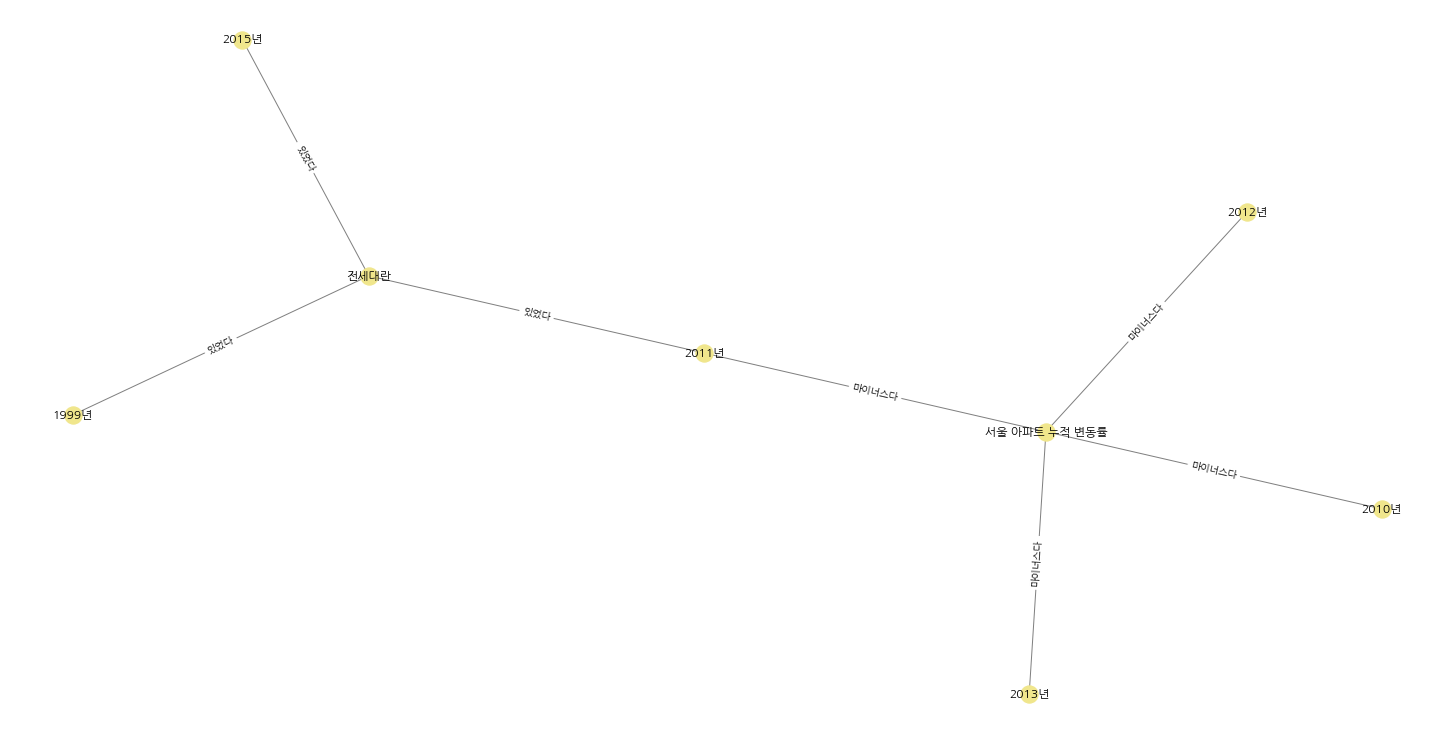

In [47]:
for i, g in enumerate(G_list):
#     GC = nx.Graph()
#     GC.add_nodes_from(nounlist[i])

#     nodes = list(spolist[i].keys())
#     edges = list(spolist[i].values())

#     for j in range(len(nodes)):
#         GC.add_edges_from([(nodes[j][0], nodes[j][1], {'verb':edges[j]})])

    plt.figure(figsize=(20, 10))
    #레이아웃
    #planar_layout, rescale_layout, fruchterman_reingold_layout, spectral_layout, random_layout, bipartite_layout,
    #circular_layout, spring_layout, kamada_kawai_layout
    pos=nx.kamada_kawai_layout(g) 
    nx.draw(g, pos, with_labels = True, font_weigth = "bold", font_family=font_name, edge_color='gray', node_color='khaki')

    labels = nx.get_edge_attributes(g,'verb')
    nx.draw_networkx_edge_labels(g, pos, edge_labels=labels, font_family=font_name)
    
    nx.draw_networkx_edges(g, pos, edgelist=key_edges[i], edge_color='r', width=3)
    
    figname = './GN_clusters_images/'+str(i)+'.png'
    #plt.savefig(figname)
    print('cluster', i)
    plt.show()

#### 그래프객체 저장(피클)

In [53]:
import pickle
 
## Save pickle
# with open("./GN_clusters_images/GC_GN","wb") as fw:
#     pickle.dump(GC, fw)

# with open("./GN_clusters_images/clusters_GN","wb") as fw:
#     pickle.dump(clusters, fw)
    
# with open("./GN_clusters_images/spolist_GN","wb") as fw:
#     pickle.dump(spolist, fw)
    
# ## Load pickle
# with open("data.GC","rb") as fr:
#     GC_saved = pickle.load(fr)
